<a href="https://colab.research.google.com/github/tekassh1/AI-Systems/blob/main/Lab5_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree

In [55]:
!pip install ucimlrepo

from math import *

import pandas as pd
import numpy as np
from numpy import nan
from google.colab import drive
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

plt.rcdefaults()
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

mushroom_dataset = fetch_ucirepo(id=73)
df = mushroom_dataset.data.original

target_feature = 'poisonous'

df_x = df.drop(columns = [target_feature])
df_y = df[target_feature]

# Выбираем случайные sqrt(n) признаков
num_of_columns = int(sqrt(len(df_x.columns)))
df_x = df.sample(n = num_of_columns, axis=1)

df = df_x
df[target_feature] = df_y

# Удаление строк с пропущенными значениями
df = df.dropna()

# Преобразование категориальных признаков в числа
label_encoder = LabelEncoder()
for column in df.columns:
    df.loc[:, column] = label_encoder.fit_transform(df[column])

**Формулы для расчёта прироста информации:**

Энтропия:

$$
Info(T) = - \sum_{j=1}^{k} \frac{\text{freq}(C_j, T)}{|T|} \log_2\left( \frac{\text{freq}(C_j, T)}{|T|} \right)
$$

Условная энтропия:
$$
Info_X(T) = \sum_{i=1}^{n} \frac{|T_i|}{|T|} Info(T_i)
$$

Оценка потенциальной информации:
$$
split_{info}(X) = - \sum_{i=1}^{n} \frac{|T_i|}{|T|} \log_2 \left( \frac{|T_i|}{|T|} \right)
$$

Нормированный прирост информации:
$$
Gain_{ratio}(X) = \frac{Info(T) - Info_X(T)}{split_{info}(X)}
$$

Где:

$k \text{ — количество классов в множестве } T $

$|T| \text{ — общее количество элементов в множестве } T$

$ |T_i| \text{ — количество элементов в подмножестве } T_i$

$ n \text{ — количество подмножеств } T_i \text{ после разбиения по признаку } X$

$freq(C_j, T) \text{ — количество элементов класса } C_j \text{ в множестве } T$




In [90]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

class DecisionTree:
    def __init__(self, df, target, max_depth):
        self.df = df
        self.target = target
        self.max_depth = max_depth
        self.tree = self.build_decision_tree(df)
        self.target_classes = df[target].unique()

    class DecisionTreeNode:
        def __init__(self, feature=None, feature_value=None, is_leaf=False, prediction=None, class_counts={}):
            self.feature = feature
            self.feature_value = feature_value
            self.is_leaf = is_leaf
            self.prediction = prediction
            self.children = {}
            self.class_counts = class_counts

        def add_child(self, value, node):
            self.children[value] = node

    def calc_entropy(self, df_target):
        probability = df_target.value_counts() / df_target.count()
        return -np.sum(probability * np.log2(probability))

    def calc_conditional_entropy(self, df, feature):
        unique_values = df[feature].unique()
        conditional_entropy = 0
        for value in unique_values:
            subset = df[df[feature] == value]
            prob = len(subset)/len(df)
            entropy = self.calc_entropy(subset[self.target])
            conditional_entropy += prob * entropy
        return conditional_entropy

    def calc_split_info(self, df, feature):
        unique_values = df[feature].unique()
        split_info = 0
        for value in unique_values:
            subset = df[df[feature] == value]
            prob = len(subset)/len(df)
            split_info -= prob * np.log2(prob + 1e-10)
        return split_info

    def calc_gain_ratio(self, df, feature):
        entropy = self.calc_entropy(df[self.target])
        conditional_entropy = self.calc_conditional_entropy(df, feature)
        split_info = self.calc_split_info(df, feature)
        if split_info == 0:
            return 0
        return (entropy - conditional_entropy) / split_info

    def find_best_feature(self, df):
        max_info_gain = 0
        best_feature = None

        total_entropy = self.calc_entropy(df[self.target])

        for feature in df.columns.drop(self.target):
            info_gain = self.calc_gain_ratio(df, feature)
            if (info_gain > max_info_gain):
                max_info_gain = info_gain
                best_feature = feature

        return best_feature

    def _same_target_class(self, df):
        return df[self.target].nunique() == 1

    def build_decision_tree(self, df, depth = 0):
        # Если мы разбили по всем признакам и остался только целевой или достигнута максимальная глубина - возвращаем наиболее часто встрчеающееся значение
        if (df.shape[1] == 1 or depth == self.max_depth):
            return self.DecisionTreeNode(is_leaf = True,
                                         prediction = df[self.target].mode()[0],
                                         class_counts = df[self.target].value_counts().to_dict())

        # Если целевой признак состоит из одних и тех же значений - возвращаем лист
        if (self._same_target_class(df)):
            class_counts = df[self.target].value_counts().to_dict()
            return self.DecisionTreeNode(is_leaf = True,
                                         prediction = df[self.target].iloc[0],
                                         class_counts = df[self.target].value_counts().to_dict())

        best_feature = self.find_best_feature(df)
        if best_feature is None:
            if df.empty:
                return self.DecisionTreeNode(is_leaf=True, prediction=None)
            else:
                return self.DecisionTreeNode(is_leaf=True,
                                             prediction=df[self.target].mode()[0],
                                             class_counts = df[self.target].value_counts().to_dict())

        root = self.DecisionTreeNode(feature=best_feature)

        # Разбиваем по каждому уникальному значению признака с наибольшим приростом информации
        for value in df[best_feature].unique():
            subset = df[df[best_feature] == value].drop(columns=[best_feature])
            if (subset.empty):
                child_node = self.DecisionTreeNode(is_leaf=True,
                                                   prediction=df[self.target].mode()[0],
                                                   class_counts = df[self.target].value_counts().to_dict())
            else:
                child_node = self.build_decision_tree(subset, depth + 1)
            root.add_child(value, child_node)

        return root

    def predict(self, df_row):
        node = self.tree
        while not node.is_leaf:
            node = node.children[df_row[node.feature]]

        prediction = node.prediction

        # Вероятность каждого класса для листа
        class_counts = node.class_counts

        total_count = sum(node.class_counts.values())
        probs = {class_label: count / total_count for class_label, count in class_counts.items()}

        # Если класса не существует в датафрейме - вероятность = 0
        for class_label in self.target_classes:
            if class_label not in probs:
                probs[class_label] = 0

        return {"prediction": prediction, "probabilities": probs}

    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.tree

        if node.is_leaf:
            print("  " * depth * 4 + f"Leaf: {node.prediction}")
        else:
            print("  " * depth* 4 + f"[Feature: {node.feature}]")
            for child_value, child_node in node.children.items():
                print("  " * (depth + 1) + f"Value: {child_value}")
                self.print_tree(child_node, depth + 1)

decisionTree = DecisionTree(train_df, target_feature, 3)

true_values = test_df[target_feature].values.tolist()
pred_values = []
pred_probabilities_positive = []

for index, row in test_df.drop(columns = [target_feature]).iterrows():
    prediction = decisionTree.predict(row)
    pred_values.append(prediction.get('prediction'))
    # p (poisonous) - positive case
    pred_probabilities_positive.append(prediction.get('probabilities').get(1))

**Подсчёт и вывод метрик**

Accuracy:  0.9064615384615384
Precision:  0.9578488372093024
Recall:  0.8427109974424553


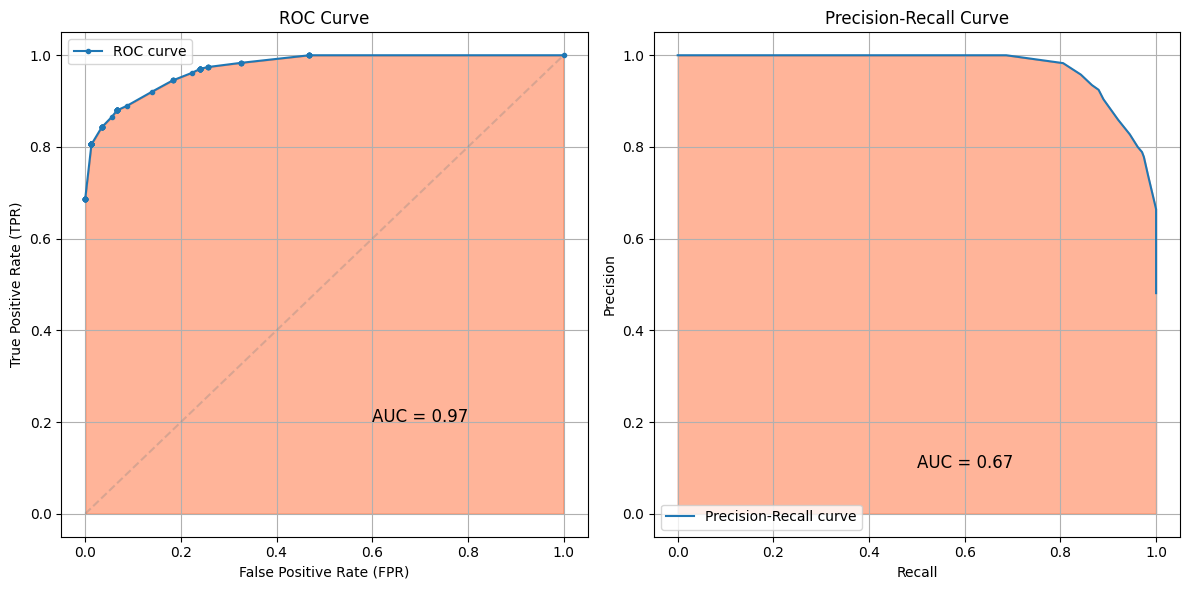

In [116]:
def calc_conf_matrix_vals(true_values, pred_values):
    true_values = np.array(true_values)
    pred_values = np.array(pred_values)

    TP = np.sum((true_values == 1) & (pred_values == 1))
    TN = np.sum((true_values == 0) & (pred_values == 0))
    FP = np.sum((true_values == 0) & (pred_values == 1))
    FN = np.sum((true_values == 1) & (pred_values == 0))

    return TP, TN, FP, FN

def calc_metrics(true_values, pred_values):
    true_values = np.array(true_values)
    pred_values = np.array(pred_values)

    TP, TN, FP, FN = calc_conf_matrix_vals(true_values, pred_values)

    Accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return Accuracy, Precision, Recall

def calculate_tpr_fpr(true_values, pred_probabilities, threshold):
    predicted_classes = (pred_probabilities >= threshold).astype(int)

    TP, TN, FP, FN = calc_conf_matrix_vals(true_values, predicted_classes)

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    return TPR, FPR

def calc_roc_curve(true_values, pred_probabilities):
    thresholds = np.linspace(0, 1, 100)

    tprs = []
    fprs = []

    for threshold in thresholds:
        TPR, FPR = calculate_tpr_fpr(true_values, pred_probabilities, threshold)
        tprs.append(TPR)
        fprs.append(FPR)

    return tprs, fprs

def calc_pr(true_values, pred_probabilities, threshold):
    predicted_classes = (pred_probabilities >= threshold).astype(int)

    TP, TN, FP, FN = calc_conf_matrix_vals(true_values, predicted_classes)

    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return Precision, Recall

def calc_pr_curve(true_values, pred_probabilities):
    thresholds = np.linspace(0, 1, 100)

    precisions = []
    recalls = []

    for threshold in thresholds:
        precision, recall = calc_pr(true_values, pred_probabilities, threshold)
        precisions.append(precision)
        recalls.append(recall)

    precisions = precisions + [1]
    recalls = recalls + [0]

    return precisions, recalls

def calc_auc(y, x):
    y = np.sort(np.array(y))
    x = np.sort(np.array(x))

    auc = np.trapz(y, x)
    return auc

Accuracy, Precision, Recall = calc_metrics(true_values, pred_values)

print("Accuracy: ", Accuracy)
print("Precision: ", Precision)
print("Recall: ", Recall)

tpr, fpr = calc_roc_curve(true_values, pred_probabilities_positive)
roc_auc = calc_auc(tpr, fpr)

precision, recall = calc_pr_curve(true_values, pred_probabilities_positive)
pr_auc = calc_auc(precision, recall)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(fpr, tpr, marker='.', label='ROC curve')
ax[0].fill_between(fpr, tpr, alpha=0.4, color='orangered')
ax[0].text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize=12, color='black')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.3)
ax[0].set_xlabel('False Positive Rate (FPR)')
ax[0].set_ylabel('True Positive Rate (TPR)')
ax[0].set_title('ROC Curve')
ax[0].legend()
ax[0].grid()

ax[1].plot(recall, precision, label='Precision-Recall curve')
ax[1].fill_between(recall, precision, alpha=0.4, color='orangered')
ax[1].text(0.5, 0.1, f'AUC = {pr_auc:.2f}', fontsize=12, color='black')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()